In [25]:
import pandas as pd
import numpy as np
import urllib.request
import shutil
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import math
from scipy.ndimage import uniform_filter1d
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('..')
# from plot_utils import download_file, extract_tar_gz, combine_ascii_files, maxc, azimuthal_equidistant_projection
from scipy.stats import linregress
import requests
import tarfile

# Custom Colormap
colors = ["#5F0F40", "#C9DAEA", "#84A07C", "#E36414", "#39A9DB", "#0081A7", "#284B63", "#FFD449"]


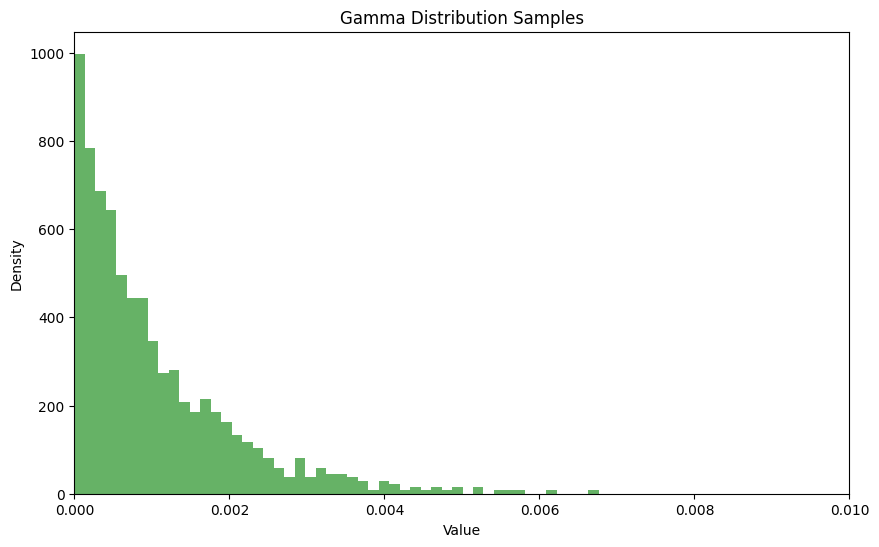

In [26]:
import numpyro
from jax import random

import numpyro.distributions as dist
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Set random seed for reproducibility
rng_key = random.PRNGKey(0)

# Define the Gamma distribution parameters
alpha = 1.0
beta = 10.0

# Sample from the Gamma distribution
samples = numpyro.sample('gamma', dist.Gamma(concentration=alpha, rate=beta), sample_shape=(1000,), rng_key=rng_key)
samples = 0.1*0.1*samples
# Plot the histogram of the samples
plt.figure(figsize=(10, 6))
plt.xlim([0, 0.01])
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g')
plt.title('Gamma Distribution Samples')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

In [27]:
# Files taken from EarthquakeNPP plot_utils.py

# Function to download the file
def download_file(url, local_filename):
	with requests.get(url, stream=True) as response:
		response.raise_for_status()  # Check if the request was successful
		with open(local_filename, 'wb') as file:
			for chunk in response.iter_content(chunk_size=8192):
				file.write(chunk)
	print(f"Downloaded {local_filename}")


def extract_tar_gz(filename, extract_path):
	if not os.path.exists(extract_path):
		os.makedirs(extract_path)
	with tarfile.open(filename, "r:gz") as tar:
		tar.extractall(path=extract_path)
	print(f"Extracted to {extract_path}")

	os.rename('SCEC_DC','raw')


def combine_ascii_files(catalog_directory):
	# Merge earthquake catalogs into a single DataFrame
	all_data = []
	for file in os.listdir(catalog_directory):
		filepath = os.path.join(catalog_directory, file)
		if file.endswith('.catalog') and os.path.isfile(filepath):
			with open(filepath, 'r') as f:
				# Read the file as ASCII
				data = f.readlines()
				# Extract column names from line 10
				column_names = data[9].strip().split()
				# Remove leading '#' if present
				column_names = [name.strip('#') for name in column_names]
				# Read the remaining lines as data
				data = data[10:]
				# Create DataFrame using column names and data
				df = pd.DataFrame([line.strip().split() for line in data], columns=column_names)
				# Merge date and time columns into a single datetime column
				df['date'] = pd.to_datetime(df['YYY/MM/DD'], format='%Y/%m/%d', errors='coerce')
				df['time'] = pd.to_timedelta(df['HH:mm:SS.ss'], errors='coerce')
				df['datetime'] = df['date'] + df['time']
				# Drop the original date and time columns
				df.drop(columns=['YYY/MM/DD', 'HH:mm:SS.ss', 'date', 'time'], inplace=True)
				# Rename columns
				df.rename(columns={'EVID': 'id', 'LAT': 'latitude', 'LON': 'longitude', 'MAG': 'magnitude','datetime': 'time'}, inplace=True)
				# Reorder columns
				# df = df[['id', 'latitude', 'longitude', 'time', 'magnitude']]
				all_data.append(df)

	if len(all_data) == 0:
		print("No earthquake catalog files found in the specified directory.")
	else:
		# Concatenate all DataFrames into a single DataFrame
		merged_data = pd.concat(all_data, ignore_index=True)

		merged_data = merged_data.dropna()

		print('final file shape: ',merged_data.shape)

		# Save merged dataset to a CSV file
		merged_data.to_csv(catalog_directory+"/SCEDC_catalog.csv", index=False)
		print("Merged dataset saved successfully as a CSV file.")

import pandas as pd
import numpy as np
import urllib.request
import requests
import tarfile
import shutil
import re
import os
import zipfile
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import math
from scipy.ndimage import uniform_filter1d
import geopandas as gpd


def download_USGS_data(start_time, end_time, max_lat, min_lat, max_lon, min_lon, minimum_magnitude):
	url = (
		"https://earthquake.usgs.gov/fdsnws/event/1/query.csv?"
		f"starttime={start_time.strftime('%Y-%m-%dT%H:%M:%S')}&endtime={end_time.strftime('%Y-%m-%dT%H:%M:%S')}"
		f"&maxlatitude={max_lat}&minlatitude={min_lat}&maxlongitude={max_lon}"
		f"&minlongitude={min_lon}&minmagnitude={minimum_magnitude}&eventtype=earthquake&orderby=time-asc"
	)

	filename = f"raw/{start_time.strftime('%Y%m%d')}_{end_time.strftime('%Y%m%d')}.csv"
	os.makedirs("raw", exist_ok=True)
	urllib.request.urlretrieve(url, filename)
	return filename

def download_USGS_in_windows(start_year, start_month, end_year, end_month, window_size_months, max_lat, min_lat, max_lon, min_lon, minimum_magnitude):
	filenames = []
	current_start = datetime(start_year, start_month, 1)
	end_time = datetime(end_year, end_month, 1) + relativedelta(months=1) - timedelta(seconds=1)
	
	while current_start <= end_time:
		current_end = current_start + relativedelta(months=window_size_months) - timedelta(seconds=1)
		if current_end > end_time:
			current_end = end_time
		filenames.append(download_USGS_data(current_start, current_end, max_lat, min_lat, max_lon, min_lon, minimum_magnitude))
		current_start = current_end + timedelta(seconds=1)
	return filenames


def combine_csv_files(filenames, destination_path, chunksize=100000):
	with open(destination_path, 'w') as wfd:
		for i, f in enumerate(filenames):
			for chunk in pd.read_csv(f, chunksize=chunksize):
				chunk.to_csv(wfd, header=(i == 0), index=False)

# Function to download the file
def download_file(url, local_filename):
	with requests.get(url, stream=True) as response:
		response.raise_for_status()  # Check if the request was successful
		with open(local_filename, 'wb') as file:
			for chunk in response.iter_content(chunk_size=8192):
				file.write(chunk)
	print(f"Downloaded {local_filename}")

def extract_tar_gz(filename, extract_path):
	if not os.path.exists(extract_path):
		os.makedirs(extract_path)
	with tarfile.open(filename, "r:gz") as tar:
		tar.extractall(path=extract_path)
	print(f"Extracted to {extract_path}")

	os.rename('SCEC_DC','raw')

def extract_zip(zip_file_path, extract_path):
	if not os.path.exists(extract_path):
		os.makedirs(extract_path)
	with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
		zip_ref.extractall(extract_path)
	print(f"Extracted to {extract_path}")

	os.remove(zip_file_path)

def download_txt_file(url,destination_path):

	if not os.path.exists(destination_path):
		os.makedirs(destination_path)

	response = requests.get(url)

	# Check if the download was successful
	if response.status_code == 200:
		# Save the content of the response to a file
		with open("tmp.txt", "wb") as file:
			file.write(response.content)
		
		# Read the downloaded file line by line
		with open("tmp.txt", "r") as file:
			lines = file.readlines()
		
		# Create an empty list to store parsed data
		data = []
		
		# Loop through each line and parse the fields using regular expression
		for line in lines:
			fields = re.split(r'\s+', line.strip())
			data.append(fields)

		# Convert the parsed data into a DataFrame
		df = pd.DataFrame(data[1:], columns=data[0])

		# Merge the datetime columns into a single datetime column
		df['time'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'SECOND']])

		# Drop the original datetime columns
		df.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'SECOND'], inplace=True)

		df.rename(columns={'EVENTID': 'id', 'LATITUDE': 'latitude', 'LONGITUDE': 'longitude', 'MAGNITUDE': 'magnitude'}, inplace=True)
		# Reorder columns
		# df = df[['id', 'latitude', 'longitude', 'time', 'magnitude']]

		# Save DataFrame to CSV
		df.to_csv(destination_path+'events.csv', index=False)
		os.remove('tmp.txt')

		print("CSV file created successfully.")
	else:
		print("Failed to download the file.")

	# os.rename('SCEC_DC','raw')

def combine_ascii_files(catalog_directory):
	# Merge earthquake catalogs into a single DataFrame
	all_data = []
	for file in os.listdir(catalog_directory):
		filepath = os.path.join(catalog_directory, file)
		if file.endswith('.catalog') and os.path.isfile(filepath):
			with open(filepath, 'r') as f:
				# Read the file as ASCII
				data = f.readlines()
				# Extract column names from line 10
				column_names = data[9].strip().split()
				# Remove leading '#' if present
				column_names = [name.strip('#') for name in column_names]
				# Read the remaining lines as data
				data = data[10:]
				# Create DataFrame using column names and data
				df = pd.DataFrame([line.strip().split() for line in data], columns=column_names)
				# Merge date and time columns into a single datetime column
				df['date'] = pd.to_datetime(df['YYY/MM/DD'], format='%Y/%m/%d', errors='coerce')
				df['time'] = pd.to_timedelta(df['HH:mm:SS.ss'], errors='coerce')
				df['datetime'] = df['date'] + df['time']
				# Drop the original date and time columns
				df.drop(columns=['YYY/MM/DD', 'HH:mm:SS.ss', 'date', 'time'], inplace=True)
				# Rename columns
				df.rename(columns={'EVID': 'id', 'LAT': 'latitude', 'LON': 'longitude', 'MAG': 'magnitude','datetime': 'time'}, inplace=True)
				# Reorder columns
				# df = df[['id', 'latitude', 'longitude', 'time', 'magnitude']]
				all_data.append(df)

	if len(all_data) == 0:
		print("No earthquake catalog files found in the specified directory.")
	else:
		# Concatenate all DataFrames into a single DataFrame
		merged_data = pd.concat(all_data, ignore_index=True)

		merged_data = merged_data.dropna()

		print('final file shape: ',merged_data.shape)

		# Save merged dataset to a CSV file
		merged_data.to_csv(catalog_directory+"/SCEDC_catalog.csv", index=False)
		print("Merged dataset saved successfully as a CSV file.")


def fmd(mag, mbin):

	mag = np.array(mag)

	mi = np.arange(min(np.round(mag/mbin)*mbin), max(np.round(mag/mbin)*mbin),mbin)

	nbm = len(mi)
	cumnbmag = np.zeros(nbm)
	nbmag = np.zeros(nbm)

	for i in range(nbm):
		cumnbmag[i] = sum((mag > mi[i]-mbin/2))

	cumnbmagtmp = np.append(cumnbmag,0)
	nbmag = abs(np.ediff1d(cumnbmagtmp))

	res = {'m':mi, 'cum':cumnbmag, 'noncum':nbmag}

	return res


def maxc(mag, mbin):

	FMD = fmd(mag, mbin)

	if len(FMD['noncum'])>0:
	# if True:

		Mc = FMD['m'][np.where(FMD['noncum']==max(FMD['noncum']))[0]][0]

	else:
		Mc = None

	return Mc

In [28]:
# Define the URL and the local filename
url = "https://scedc.caltech.edu/ftp/catalogs/SCEC_DC/SCEDC_catalogs.tar.gz"
local_filename = "SCEDC_catalogs.tar.gz"
extract_path = "./"

# Download and extract the file
download_file(url, local_filename)
extract_tar_gz(local_filename, extract_path)
combine_ascii_files('./raw')

Downloaded SCEDC_catalogs.tar.gz
Extracted to ./


OSError: [Errno 66] Directory not empty: 'SCEC_DC' -> 'raw'

In [ ]:
raw_catalog = pd.read_csv("raw/SCEDC_catalog.csv")
raw_catalog['time'] = pd.to_datetime(raw_catalog['time'])
raw_catalog = raw_catalog.sort_values(by='time')
raw_catalog = raw_catalog[["time", "longitude", "latitude","magnitude"]].dropna()
raw_catalog.reset_index(drop=False, inplace=True)
print('the raw catalog has', len(raw_catalog),'events')

the raw catalog has 890615 events


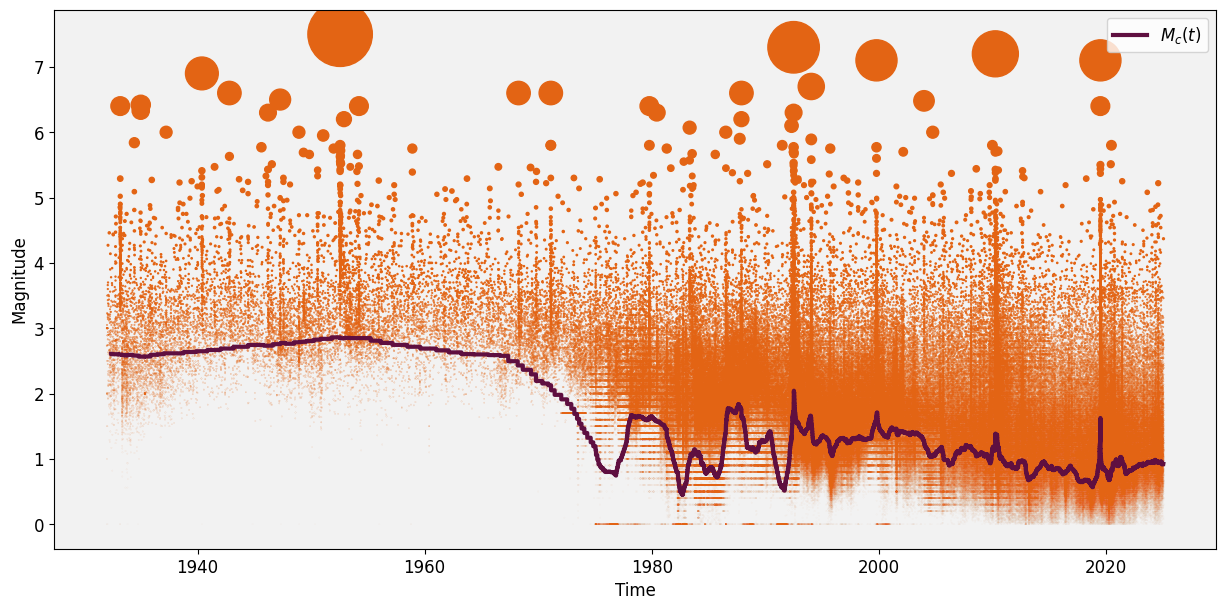

In [ ]:
%matplotlib inline
plt.figure(figsize=(15, 7))
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Compute M_c(t) across the raw catalog
window_size=300
nwindows = math.floor(len(raw_catalog['magnitude'])/window_size)

Mc_t = [0]*nwindows
mid_time = [0]*nwindows

comp_T = raw_catalog['time']
comp_M = raw_catalog['magnitude']

for i in range(nwindows):
    mid_time[i] =  pd.Timestamp(pd.Series(comp_T[i*window_size:(i+1)*window_size]).mean())

    window = comp_M[i*window_size:(i+1)*window_size]
    Mc_t[i] = maxc(window,0.05)

# Smooth M_c(t) for plotting
Mc_t = uniform_filter1d(Mc_t, size=40)

# Plotting
plt.step(mid_time,Mc_t,colors[0],label=r'$M_c(t)$',lw=3)
z = (9.5**raw_catalog['magnitude'])*0.0001
plt.scatter(raw_catalog['time'],raw_catalog['magnitude'],s=z,color =colors[3])
plt.xlabel('Time',fontsize=12)
plt.ylabel('Magnitude',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

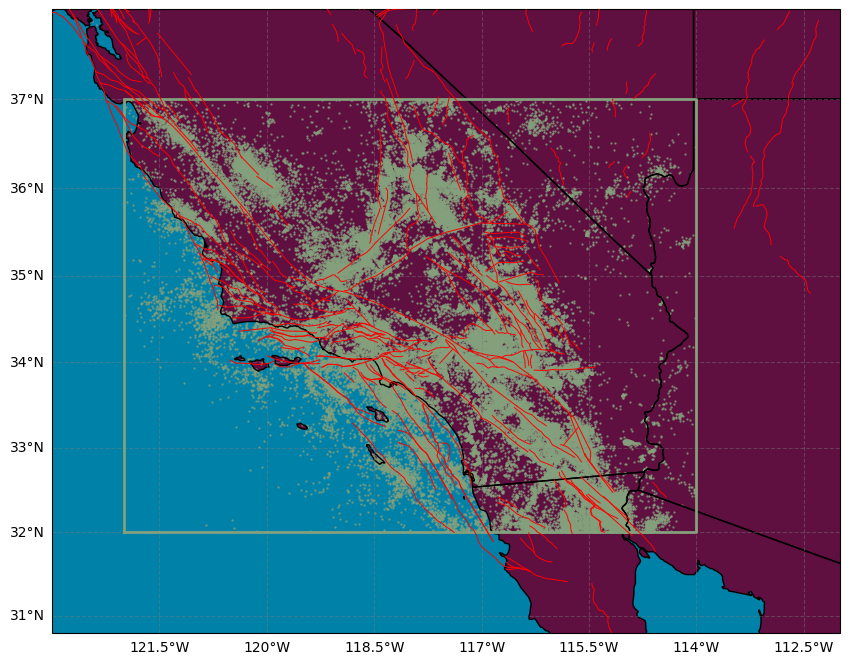

In [ ]:
# Read the GEM fault data
gdf = gpd.read_file('../data/gem_active_faults.gpkg')
faults = gdf.geometry

# Filter the GeoDataFrame to include only geometries within the specified extent
max_lat, min_lat, max_lon, min_lon = 38, 30.79, -110, -130
filtered_gdf = gdf.cx[min_lon:max_lon, min_lat:max_lat]

# Extract the geometry of the faults within the specified extent
faults_within_extent = filtered_gdf.geometry


# Create a figure with Cartopy
fig = plt.figure(figsize=(10.5, 8.1))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([-123, -112, 30.79, 38], crs=ccrs.PlateCarree())

# Add colored land and ocean
ax.add_feature(cfeature.LAND, facecolor="#5F0F40")
ax.add_feature(cfeature.OCEAN, facecolor="#0081A7")
ax.add_feature(cfeature.STATES, edgecolor='black')


# Plot the faults
for geom in faults_within_extent:
    ax.plot(geom.xy[0], geom.xy[1], color='red', transform=ccrs.PlateCarree(),zorder=10,linewidth=0.7)


# Add gridlines with customization
gl = ax.gridlines(draw_labels=True, color='gray', linestyle='--', alpha=0.4)
gl.right_labels = False
gl.top_labels = False
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)


# Plot polygon
polygon_coords = np.load('../data/SCEDC_shape.npy')
plot_polygon_coords = np.append(polygon_coords, [polygon_coords[0]], axis=0)
ax.plot(plot_polygon_coords[:, 1], plot_polygon_coords[:, 0], transform=ccrs.PlateCarree(), color=colors[2], lw=2)

plot_catalog = raw_catalog[raw_catalog['magnitude']>=1.8]
# Plot events
ax.scatter(plot_catalog['longitude'], plot_catalog['latitude'], transform=ccrs.PlateCarree(), s=0.4, color=colors[2], alpha=0.8)
plt.show()

In [ ]:
# import pickle as pkl
# with open('../res/earthquake_4_param/x_sims_all_round_1000.pkl', 'rb') as f:
#     x_sims_all_round = pkl.load(f)


# with open('../res/earthquake_4_param/x_sims_all_round_2.pkl', 'wb') as f:
#     pkl.dump(x_sims_all_round, f)
    
# with open('../res/earthquake_4_param/thetas_all_round_1000.pkl', 'rb') as f:
#     x_sims_all_round = pkl.load(f)


# with open('../res/earthquake_4_param/thetas_all_round_2.pkl', 'wb') as f:
#     pkl.dump(x_sims_all_round, f)



In [ ]:
import pickle as pkl
with open('../res/earthquake_4_param/x_sims_all_round_2.pkl', 'rb') as f:
    x_sims_all_round = pkl.load(f)
    
with open('../res/earthquake_4_param/thetas_all_round_2.pkl', 'rb') as f:
    thetas_all_round = pkl.load(f)

In [ ]:
thetas_all_round.shape

(15000, 4)

In [ ]:
with open("../res/earthquake_4_param/thetas_all_round_1.pkl", "rb") as f:
    thetas_all = pkl.load(f)

with open("../res/earthquake_4_param/x_sims_reduced_all_round_1.pkl", "rb") as f:
    x_sims_all = pkl.load(f)


In [ ]:
x_sims_all_round[-20:, 1]

Array([ -8.490155 , -11.59065  , -11.176338 , -10.754921 , -12.206056 ,
       -11.139712 ,  -9.29205  , -10.053572 , -11.395166 ,  -9.241693 ,
       -10.808059 , -10.242819 , -10.2666445, -10.728544 , -10.354044 ,
        -9.867337 , -11.232465 ,  -9.587542 ,  -8.375293 , -10.576983 ],      dtype=float32)

In [ ]:
import pickle as pkl
with open ('../res/earthquake_4_param/thetas_all_final.pkl', 'rb') as f:
    thetas_all_final = pkl.load(f)



In [ ]:
# from rsnl.visualisations import plot_theta_posterior
# import arviz as az
# import matplotlib.pyplot as plt

# for i in range(4):
#     for j in range(4):
#         if i != j:
#             plt.scatter(thetas_all_round[:, i], thetas_all_round[:, j], s=0.5, color=colors[0], alpha=0.7)
#             plt.show()
#             plt.clf()

# # colors = ["#5F0F40", "#C9DAEA", "#84A07C", "#E36414", "#39A9DB", "#0081A7", "#284B63", "#FFD449"]

# # for i in range(4):
# #     plt.hist(thetas_all_round[:, i], bins=50, color=colors[0], alpha=0.7)
# #     plt.show()
# #     plt.clf()

# # plt.scatter(thetas_all_round[:, 0], thetas_all_round[:, 1], s=0.5, color=colors[0], alpha=0.7)


In [ ]:
thetas_all.shape

(3000, 4)

In [ ]:
from etas.simulation import generate_catalog, generate_background_events
from mm_sbi_review.examples.earthquake import earthquake_sim_fn_4_param, sum_fn, early_return
import jax.random as random

# TODO: posterior predictive checks
num_sims = 100
catalogs = []
rng_key = random.PRNGKey(0)
for i in range(num_sims):
    thetas = thetas_all_final[i, :]
    rng_key, subkey = random.split(rng_key)
    catalogs.append(earthquake_sim_fn_4_param(subkey, *thetas))

14-02-25 12:09:07 : INFO     : etas.simulation - generating background events..
14-02-25 12:09:07 : INFO     : etas.simulation -   number of background events needed: 2050
14-02-25 12:09:07 : INFO     : etas.simulation -   generating 2460 to throw away those outside the polygon
14-02-25 12:09:07 : INFO     : etas.simulation -   number of background events: 2050
14-02-25 12:09:07 : INFO     : etas.simulation - 
  branching ratio: 0.3050075077309226
14-02-25 12:09:07 : INFO     : etas.simulation -   expected total number of events (if time were infinite): 2949.6721515752865
14-02-25 12:09:07 : INFO     : etas.simulation - 

simulating aftershocks of generation 0..
14-02-25 12:09:07 : INFO     : etas.simulation -   number of events with aftershocks: 550
14-02-25 12:09:07 : INFO     : etas.simulation -   number of generated aftershocks: 607
14-02-25 12:09:07 : INFO     : etas.simulation - 

simulating aftershocks of generation 1..
14-02-25 12:09:07 : INFO     : etas.simulation -   number o

mu, k0, c, rho: 4.134483e-09 0.004030192 0.27961278 1.9288226
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 6.651792e-07 0.0033591462 0.5559971 1.7619778
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 1.7323052e-09 0.0030652697 0.16273502 1.3325007
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 4.595121e-07 0.0006438543 0.53078115 1.7159724
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:09:07 : INFO     : etas.simulation -   number of generated aftershocks: 1
14-02-25 12:09:07 : INFO     : etas.simulation - 

simulating aftershocks of generation 7..
14-02-25 12:09:07 : INFO     : etas.simulation -   number of events with aftershocks: 1
14-02-25 12:09:07 : INFO     : etas.simulation -   number of generated aftershocks: 1
14-02-25 12:09:07 : INFO     : etas.simulation - 

simulating aftershocks of generation 8..
14-02-25 12:09:07 : INFO     : etas.simulation -   number of events with aftershocks: 0
14-02-25 12:09:07 : INFO     : etas.simulation - 

total events simulated: 2888
14-02-25 12:09:07 : INFO     : etas.simulation - inside the polygon: 2886
14-02-25 12:09:07 : INFO     : etas.simulation - generating background events..
14-02-25 12:09:07 : INFO     : etas.simulation -   number of background events needed: 1594
14-02-25 12:09:07 : INFO     : etas.simulation -   generating 1913 to throw away those outside the polygon
14-02-25 12:09:07 : INFO     : etas

mu, k0, c, rho: 3.853669e-15 0.006044459 0.09711895 1.3638439
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 6.211962e-08 0.003726958 0.1237061 1.6732333
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 3.6344923e-07 0.0023316161 0.22965132 1.7326949
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:09:07 : INFO     : etas.simulation -   number of generated aftershocks: 5065
14-02-25 12:09:07 : INFO     : etas.simulation - 

simulating aftershocks of generation 7..
14-02-25 12:09:07 : INFO     : etas.simulation -   number of events with aftershocks: 3572
14-02-25 12:09:07 : INFO     : etas.simulation -   number of generated aftershocks: 5918
14-02-25 12:09:07 : INFO     : etas.simulation - 

simulating aftershocks of generation 8..
14-02-25 12:09:07 : INFO     : etas.simulation -   number of events with aftershocks: 4145
14-02-25 12:09:07 : INFO     : etas.simulation -   number of generated aftershocks: 6807
14-02-25 12:09:07 : INFO     : etas.simulation - 

simulating aftershocks of generation 9..
14-02-25 12:09:07 : INFO     : etas.simulation -   number of events with aftershocks: 4818
14-02-25 12:09:08 : INFO     : etas.simulation -   number of generated aftershocks: 7966
14-02-25 12:09:08 : INFO     : etas.simulation - 

simulating aftershocks of generation 10..
14

TOO MANY EVENTS
mu, k0, c, rho: 9.808095e-07 0.0035735455 0.42373565 1.3293651
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:09:33 : INFO     : etas.simulation -   number of generated aftershocks: 11920
14-02-25 12:09:33 : INFO     : etas.simulation - 

simulating aftershocks of generation 4..
14-02-25 12:09:33 : INFO     : etas.simulation -   number of events with aftershocks: 8669
14-02-25 12:09:34 : INFO     : etas.simulation -   number of generated aftershocks: 15575
14-02-25 12:09:34 : INFO     : etas.simulation - 

simulating aftershocks of generation 5..
14-02-25 12:09:34 : INFO     : etas.simulation -   number of events with aftershocks: 11278
14-02-25 12:09:34 : INFO     : etas.simulation -   number of generated aftershocks: 20177
14-02-25 12:09:34 : INFO     : etas.simulation - 

simulating aftershocks of generation 6..
14-02-25 12:09:34 : INFO     : etas.simulation -   number of events with aftershocks: 14612
14-02-25 12:09:34 : INFO     : etas.simulation -   number of generated aftershocks: 26024
14-02-25 12:09:34 : INFO     : etas.simulation - 

simulating aftershocks of generation 7

TOO MANY EVENTS
mu, k0, c, rho: 6.0551325e-13 0.001986733 0.1672776 1.3071492
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 6.0182737e-10 0.00065602135 0.81957275 1.5055175
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 1.9654541e-07 0.0017247924 0.28133667 1.582562
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:09:48 : INFO     : etas.simulation -   number of events with aftershocks: 2
14-02-25 12:09:48 : INFO     : etas.simulation -   number of generated aftershocks: 2
14-02-25 12:09:48 : INFO     : etas.simulation - 

simulating aftershocks of generation 20..
14-02-25 12:09:48 : INFO     : etas.simulation -   number of events with aftershocks: 2
14-02-25 12:09:48 : INFO     : etas.simulation -   number of generated aftershocks: 3
14-02-25 12:09:48 : INFO     : etas.simulation - 

simulating aftershocks of generation 21..
14-02-25 12:09:48 : INFO     : etas.simulation -   number of events with aftershocks: 2
14-02-25 12:09:48 : INFO     : etas.simulation -   number of generated aftershocks: 3
14-02-25 12:09:48 : INFO     : etas.simulation - 

simulating aftershocks of generation 22..
14-02-25 12:09:48 : INFO     : etas.simulation -   number of events with aftershocks: 2
14-02-25 12:09:48 : INFO     : etas.simulation -   number of generated aftershocks: 2
14-02-25 12:09:48 : INFO 

mu, k0, c, rho: 1.5516499e-09 0.0016760381 0.37203237 1.7639885
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 2.3465967e-08 0.0015193239 0.19363916 1.3256147
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 5.7138254e-07 0.0013110414 0.2847252 1.3123194
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:09:48 : INFO     : etas.simulation -   number of generated aftershocks: 8
14-02-25 12:09:48 : INFO     : etas.simulation - 

simulating aftershocks of generation 8..
14-02-25 12:09:48 : INFO     : etas.simulation -   number of events with aftershocks: 3
14-02-25 12:09:48 : INFO     : etas.simulation -   number of generated aftershocks: 3
14-02-25 12:09:48 : INFO     : etas.simulation - 

simulating aftershocks of generation 9..
14-02-25 12:09:48 : INFO     : etas.simulation -   number of events with aftershocks: 1
14-02-25 12:09:48 : INFO     : etas.simulation -   number of generated aftershocks: 1
14-02-25 12:09:48 : INFO     : etas.simulation - 

simulating aftershocks of generation 10..
14-02-25 12:09:48 : INFO     : etas.simulation -   number of events with aftershocks: 0
14-02-25 12:09:48 : INFO     : etas.simulation - 

total events simulated: 4909
14-02-25 12:09:48 : INFO     : etas.simulation - inside the polygon: 4908
14-02-25 12:09:48 : INFO     : etas.simulation 

mu, k0, c, rho: 3.3703838e-08 0.00072778645 0.60348505 1.1142286
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 2.1245872e-07 0.0008728273 0.28502735 1.4153552
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 2.7242294e-08 0.001505299 0.22773318 1.2896767
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:09:48 : INFO     : etas.simulation - 

simulating aftershocks of generation 3..
14-02-25 12:09:48 : INFO     : etas.simulation -   number of events with aftershocks: 12
14-02-25 12:09:48 : INFO     : etas.simulation -   number of generated aftershocks: 16
14-02-25 12:09:48 : INFO     : etas.simulation - 

simulating aftershocks of generation 4..
14-02-25 12:09:48 : INFO     : etas.simulation -   number of events with aftershocks: 5
14-02-25 12:09:48 : INFO     : etas.simulation -   number of generated aftershocks: 9
14-02-25 12:09:48 : INFO     : etas.simulation - 

simulating aftershocks of generation 5..
14-02-25 12:09:48 : INFO     : etas.simulation -   number of events with aftershocks: 3
14-02-25 12:09:48 : INFO     : etas.simulation -   number of generated aftershocks: 3
14-02-25 12:09:48 : INFO     : etas.simulation - 

simulating aftershocks of generation 6..
14-02-25 12:09:48 : INFO     : etas.simulation -   number of events with aftershocks: 3
14-02-25 12:09:48 : 

mu, k0, c, rho: 2.0108791e-06 0.0012795774 0.22188497 1.4648674
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:09:49 : INFO     : etas.simulation -   number of events with aftershocks: 2
14-02-25 12:09:49 : INFO     : etas.simulation -   number of generated aftershocks: 4
14-02-25 12:09:49 : INFO     : etas.simulation - 

simulating aftershocks of generation 12..
14-02-25 12:09:49 : INFO     : etas.simulation -   number of events with aftershocks: 1
14-02-25 12:09:49 : INFO     : etas.simulation -   number of generated aftershocks: 1
14-02-25 12:09:49 : INFO     : etas.simulation - 

simulating aftershocks of generation 13..
14-02-25 12:09:49 : INFO     : etas.simulation -   number of events with aftershocks: 0
14-02-25 12:09:49 : INFO     : etas.simulation - 

total events simulated: 18463
14-02-25 12:09:49 : INFO     : etas.simulation - inside the polygon: 18451
14-02-25 12:09:49 : INFO     : etas.simulation - generating background events..
14-02-25 12:09:49 : INFO     : etas.simulation -   number of background events needed: 148
14-02-25 12:09:49 : INFO     : etas.simulation -   

mu, k0, c, rho: 3.181844e-08 0.0030261427 0.73682886 1.7749352
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:09:49 : INFO     : etas.simulation -   number of generated aftershocks: 7357
14-02-25 12:09:49 : INFO     : etas.simulation - 

simulating aftershocks of generation 12..
14-02-25 12:09:49 : INFO     : etas.simulation -   number of events with aftershocks: 5657
14-02-25 12:09:49 : INFO     : etas.simulation -   number of generated aftershocks: 9827
14-02-25 12:09:49 : INFO     : etas.simulation - 

simulating aftershocks of generation 13..
14-02-25 12:09:49 : INFO     : etas.simulation -   number of events with aftershocks: 7524
14-02-25 12:09:49 : INFO     : etas.simulation -   number of generated aftershocks: 13150
14-02-25 12:09:49 : INFO     : etas.simulation - 

simulating aftershocks of generation 14..
14-02-25 12:09:49 : INFO     : etas.simulation -   number of events with aftershocks: 10025
14-02-25 12:09:49 : INFO     : etas.simulation -   number of generated aftershocks: 17536
14-02-25 12:09:49 : INFO     : etas.simulation - 

simulating aftershocks of generation 1

TOO MANY EVENTS
mu, k0, c, rho: 7.931245e-08 0.00090033165 0.068151504 1.7610432
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 1.3895179e-07 0.0009978998 0.07746024 1.720137
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 5.1376926e-08 0.00041625474 0.38708282 1.5262847
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:10:00 : INFO     : etas.simulation -   number of generated aftershocks: 30
14-02-25 12:10:00 : INFO     : etas.simulation - 

simulating aftershocks of generation 1..
14-02-25 12:10:00 : INFO     : etas.simulation -   number of events with aftershocks: 5
14-02-25 12:10:00 : INFO     : etas.simulation -   number of generated aftershocks: 6
14-02-25 12:10:00 : INFO     : etas.simulation - 

simulating aftershocks of generation 2..
14-02-25 12:10:00 : INFO     : etas.simulation -   number of events with aftershocks: 2
14-02-25 12:10:00 : INFO     : etas.simulation -   number of generated aftershocks: 2
14-02-25 12:10:00 : INFO     : etas.simulation - 

simulating aftershocks of generation 3..
14-02-25 12:10:00 : INFO     : etas.simulation -   number of events with aftershocks: 0
14-02-25 12:10:00 : INFO     : etas.simulation - 

total events simulated: 260
14-02-25 12:10:00 : INFO     : etas.simulation - inside the polygon: 260
14-02-25 12:10:00 : INFO     : etas.simulation - 

mu, k0, c, rho: 9.388361e-07 0.00019523357 0.1321659 1.7023419
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 1.2127455e-14 0.0024668118 0.0103507675 1.0278152
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 1.45122e-14 0.0023501632 0.0118135335 1.0259298
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 2.506674e-15 0.0029856577 0.75753105 1.1785583
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 1.18134e-14 0.00012068831 0.3186051 1.9087443
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 1.6510592e-19 1.4055181e-05 0.7220082 1.6155685
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 1.5295618e-09 4.4169432e-05 0.6562338 1.3669633
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 7.4483566e-08 0.00028883078 0.44845912 1.1374667
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 1.6575227e-06 0.00038148262 0.6228642 1.3126621
s:  ../data/input_data/

14-02-25 12:10:00 : INFO     : etas.simulation -   number of background events: 6889
14-02-25 12:10:00 : INFO     : etas.simulation - 
  branching ratio: 0.13770815046770007
14-02-25 12:10:00 : INFO     : etas.simulation -   expected total number of events (if time were infinite): 7989.17443524085
14-02-25 12:10:00 : INFO     : etas.simulation - 

simulating aftershocks of generation 0..
14-02-25 12:10:00 : INFO     : etas.simulation -   number of events with aftershocks: 909
14-02-25 12:10:00 : INFO     : etas.simulation -   number of generated aftershocks: 922
14-02-25 12:10:00 : INFO     : etas.simulation - 

simulating aftershocks of generation 1..
14-02-25 12:10:00 : INFO     : etas.simulation -   number of events with aftershocks: 119
14-02-25 12:10:00 : INFO     : etas.simulation -   number of generated aftershocks: 122
14-02-25 12:10:00 : INFO     : etas.simulation - 

simulating aftershocks of generation 2..
14-02-25 12:10:00 : INFO     : etas.simulation -   number of events w

mu, k0, c, rho: 2.9828013e-06 9.610077e-05 0.7050018 1.6225201
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 4.941927e-06 8.5378e-05 0.70928496 1.4531882
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:10:01 : INFO     : etas.simulation -   number of background events: 21419
14-02-25 12:10:01 : INFO     : etas.simulation - 
  branching ratio: 0.03261114514269042
14-02-25 12:10:01 : INFO     : etas.simulation -   expected total number of events (if time were infinite): 22141.044826446046
14-02-25 12:10:01 : INFO     : etas.simulation - 

simulating aftershocks of generation 0..
14-02-25 12:10:01 : INFO     : etas.simulation -   number of events with aftershocks: 694
14-02-25 12:10:01 : INFO     : etas.simulation -   number of generated aftershocks: 674
14-02-25 12:10:01 : INFO     : etas.simulation - 

simulating aftershocks of generation 1..
14-02-25 12:10:01 : INFO     : etas.simulation -   number of events with aftershocks: 21
14-02-25 12:10:01 : INFO     : etas.simulation -   number of generated aftershocks: 19
14-02-25 12:10:01 : INFO     : etas.simulation - 

simulating aftershocks of generation 2..
14-02-25 12:10:01 : INFO     : etas.simulation -   number of events 

mu, k0, c, rho: 2.6622258e-05 0.00065584324 0.57969624 1.3540269
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:10:01 : INFO     : etas.simulation -   number of background events: 115381
14-02-25 12:10:01 : INFO     : etas.simulation - 
  branching ratio: 0.24326609057563875
14-02-25 12:10:01 : INFO     : etas.simulation -   expected total number of events (if time were infinite): 152472.35331078133
14-02-25 12:10:01 : INFO     : etas.simulation - 

simulating aftershocks of generation 0..
14-02-25 12:10:01 : INFO     : etas.simulation -   number of events with aftershocks: 24793
14-02-25 12:10:02 : INFO     : etas.simulation -   number of generated aftershocks: 27092
14-02-25 12:10:02 : INFO     : etas.simulation - 

simulating aftershocks of generation 1..
14-02-25 12:10:02 : INFO     : etas.simulation -   number of events with aftershocks: 5849
14-02-25 12:10:02 : INFO     : etas.simulation -   number of generated aftershocks: 6415
14-02-25 12:10:02 : INFO     : etas.simulation - 

simulating aftershocks of generation 2..
14-02-25 12:10:02 : INFO     : etas.simulation -   number o

mu, k0, c, rho: 2.5817294e-06 0.0032510262 0.83973044 1.7452462
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:10:02 : INFO     : etas.simulation -   number of generated aftershocks: 23305
14-02-25 12:10:02 : INFO     : etas.simulation - 

simulating aftershocks of generation 2..
14-02-25 12:10:02 : INFO     : etas.simulation -   number of events with aftershocks: 18031
14-02-25 12:10:02 : INFO     : etas.simulation -   number of generated aftershocks: 33127
14-02-25 12:10:02 : INFO     : etas.simulation - 

simulating aftershocks of generation 3..
14-02-25 12:10:02 : INFO     : etas.simulation -   number of events with aftershocks: 25653
14-02-25 12:10:02 : INFO     : etas.simulation -   number of generated aftershocks: 46992
14-02-25 12:10:02 : INFO     : etas.simulation - 

simulating aftershocks of generation 4..
14-02-25 12:10:02 : INFO     : etas.simulation -   number of events with aftershocks: 36573
14-02-25 12:10:03 : INFO     : etas.simulation -   number of generated aftershocks: 67175
14-02-25 12:10:03 : INFO     : etas.simulation - 

simulating aftershocks of generation 

TOO MANY EVENTS
mu, k0, c, rho: 1.6947483e-08 0.0013599258 0.48178998 1.8458849
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 3.13726e-09 0.0033816707 0.7849028 1.9619792
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 4.9016165e-08 0.0047216397 0.8187487 1.9607191
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 6.934988e-10 0.0045265276 0.49633938 1.7738174
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 2.2212543e-09 0.0040616263 0.502252 1.770565
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 2.8747964e-09 0.0044507813 0.408168 1.661896
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 5.527856e-07 0.002690588 0.64674187 1.6527796
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:10:12 : INFO     : etas.simulation -   number of generated aftershocks: 3178
14-02-25 12:10:12 : INFO     : etas.simulation - 

simulating aftershocks of generation 2..
14-02-25 12:10:12 : INFO     : etas.simulation -   number of events with aftershocks: 2172
14-02-25 12:10:12 : INFO     : etas.simulation -   number of generated aftershocks: 3593
14-02-25 12:10:12 : INFO     : etas.simulation - 

simulating aftershocks of generation 3..
14-02-25 12:10:12 : INFO     : etas.simulation -   number of events with aftershocks: 2428
14-02-25 12:10:12 : INFO     : etas.simulation -   number of generated aftershocks: 3944
14-02-25 12:10:12 : INFO     : etas.simulation - 

simulating aftershocks of generation 4..
14-02-25 12:10:12 : INFO     : etas.simulation -   number of events with aftershocks: 2746
14-02-25 12:10:12 : INFO     : etas.simulation -   number of generated aftershocks: 4504
14-02-25 12:10:12 : INFO     : etas.simulation - 

simulating aftershocks of generation 5..
14-

mu, k0, c, rho: 1.9312247e-06 0.0027221888 0.59595907 1.7561978
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:10:57 : INFO     : etas.simulation -   number of generated aftershocks: 13433
14-02-25 12:10:57 : INFO     : etas.simulation - 

simulating aftershocks of generation 2..
14-02-25 12:10:57 : INFO     : etas.simulation -   number of events with aftershocks: 9781
14-02-25 12:10:57 : INFO     : etas.simulation -   number of generated aftershocks: 16720
14-02-25 12:10:57 : INFO     : etas.simulation - 

simulating aftershocks of generation 3..
14-02-25 12:10:57 : INFO     : etas.simulation -   number of events with aftershocks: 12181
14-02-25 12:10:57 : INFO     : etas.simulation -   number of generated aftershocks: 20862
14-02-25 12:10:57 : INFO     : etas.simulation - 

simulating aftershocks of generation 4..
14-02-25 12:10:57 : INFO     : etas.simulation -   number of events with aftershocks: 15194
14-02-25 12:10:57 : INFO     : etas.simulation -   number of generated aftershocks: 26152
14-02-25 12:10:57 : INFO     : etas.simulation - 

simulating aftershocks of generation 5

TOO MANY EVENTS
mu, k0, c, rho: 4.2052147e-07 0.0049960893 0.73128647 1.8832862
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 3.3739101e-07 0.0048760655 0.548235 1.8528314
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 2.270646e-06 0.0049974974 0.38073856 1.8797354
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 4.209486e-06 0.0048161726 0.37820888 1.8712479
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 8.2914755e-07 0.0031438281 0.5068567 1.802832
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 2.3382074e-07 0.003791973 0.63741624 1.8347943
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 3.759381e-09 0.0009885116 0.61251664 1.8253219
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 6.9652756e-11 0.0013117047 0.36045235 1.057719
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 1.2252334e-10 0.0016945186 0.2008

14-02-25 12:11:13 : INFO     : etas.simulation -   number of generated aftershocks: 13518
14-02-25 12:11:13 : INFO     : etas.simulation - 

simulating aftershocks of generation 1..
14-02-25 12:11:13 : INFO     : etas.simulation -   number of events with aftershocks: 9020
14-02-25 12:11:13 : INFO     : etas.simulation -   number of generated aftershocks: 14393
14-02-25 12:11:13 : INFO     : etas.simulation - 

simulating aftershocks of generation 2..
14-02-25 12:11:13 : INFO     : etas.simulation -   number of events with aftershocks: 9644
14-02-25 12:11:13 : INFO     : etas.simulation -   number of generated aftershocks: 15227
14-02-25 12:11:13 : INFO     : etas.simulation - 

simulating aftershocks of generation 3..
14-02-25 12:11:13 : INFO     : etas.simulation -   number of events with aftershocks: 10209
14-02-25 12:11:13 : INFO     : etas.simulation -   number of generated aftershocks: 16048
14-02-25 12:11:13 : INFO     : etas.simulation - 

simulating aftershocks of generation 4.

mu, k0, c, rho: 8.707829e-08 0.000495289 0.937225 1.9819899
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 7.320545e-07 0.0005277467 0.58800495 1.9504902
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:11:24 : INFO     : etas.simulation -   number of events with aftershocks: 0
14-02-25 12:11:24 : INFO     : etas.simulation - 

total events simulated: 4522
14-02-25 12:11:24 : INFO     : etas.simulation - inside the polygon: 4519
14-02-25 12:11:24 : INFO     : etas.simulation - generating background events..
14-02-25 12:11:24 : INFO     : etas.simulation -   number of background events needed: 46
14-02-25 12:11:24 : INFO     : etas.simulation -   generating 55 to throw away those outside the polygon
14-02-25 12:11:24 : INFO     : etas.simulation -   number of background events: 46
14-02-25 12:11:24 : INFO     : etas.simulation - 
  branching ratio: 0.25492285973424644
14-02-25 12:11:24 : INFO     : etas.simulation -   expected total number of events (if time were infinite): 61.73857378524961
14-02-25 12:11:24 : INFO     : etas.simulation - 

simulating aftershocks of generation 0..
14-02-25 12:11:24 : INFO     : etas.simulation -   number of events with aftershocks: 10
14-0

mu, k0, c, rho: 1.1917018e-08 0.0004262109 0.55200404 1.9874673
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 5.9324354e-09 0.00037466738 0.5170292 1.9794371
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 5.9976933e-06 0.00057438994 0.1522546 1.6775014
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:11:24 : INFO     : etas.simulation -   number of generated aftershocks: 7516
14-02-25 12:11:24 : INFO     : etas.simulation - 

simulating aftershocks of generation 1..
14-02-25 12:11:24 : INFO     : etas.simulation -   number of events with aftershocks: 2014
14-02-25 12:11:24 : INFO     : etas.simulation -   number of generated aftershocks: 2268
14-02-25 12:11:24 : INFO     : etas.simulation - 

simulating aftershocks of generation 2..
14-02-25 12:11:24 : INFO     : etas.simulation -   number of events with aftershocks: 566
14-02-25 12:11:24 : INFO     : etas.simulation -   number of generated aftershocks: 610
14-02-25 12:11:24 : INFO     : etas.simulation - 

simulating aftershocks of generation 3..
14-02-25 12:11:24 : INFO     : etas.simulation -   number of events with aftershocks: 153
14-02-25 12:11:24 : INFO     : etas.simulation -   number of generated aftershocks: 168
14-02-25 12:11:24 : INFO     : etas.simulation - 

simulating aftershocks of generation 4..
14-02-2

mu, k0, c, rho: 3.625682e-07 0.00012267049 0.9645269 1.2084796
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 1.7513315e-07 0.00017096274 0.8884636 1.8799555
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 1.992549e-08 0.00019183365 0.8623962 1.8829046
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 7.037917e-09 0.00036275949 0.8717538 1.8964338
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 9.57479e-07 0.0005540219 0.95654947 1.9738889
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:11:24 : INFO     : etas.simulation -   number of background events needed: 4113
14-02-25 12:11:24 : INFO     : etas.simulation -   generating 4936 to throw away those outside the polygon
14-02-25 12:11:24 : INFO     : etas.simulation -   number of background events: 4113
14-02-25 12:11:24 : INFO     : etas.simulation - 
  branching ratio: 0.3065894226777093
14-02-25 12:11:24 : INFO     : etas.simulation -   expected total number of events (if time were infinite): 5931.550706773133
14-02-25 12:11:24 : INFO     : etas.simulation - 

simulating aftershocks of generation 0..
14-02-25 12:11:24 : INFO     : etas.simulation -   number of events with aftershocks: 1076
14-02-25 12:11:24 : INFO     : etas.simulation -   number of generated aftershocks: 1217
14-02-25 12:11:24 : INFO     : etas.simulation - 

simulating aftershocks of generation 1..
14-02-25 12:11:24 : INFO     : etas.simulation -   number of events with aftershocks: 318
14-02-25 12:11:24 : INFO     : etas.simulation -

mu, k0, c, rho: 1.7572467e-06 0.00044354176 0.9469866 1.965972
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 5.1039715e-06 0.0020916436 0.025023457 1.0740232
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:11:24 : INFO     : etas.simulation -   number of background events: 22009
14-02-25 12:11:24 : INFO     : etas.simulation - 
  branching ratio: 0.961470865533577
14-02-25 12:11:24 : INFO     : etas.simulation -   expected total number of events (if time were infinite): 571230.0653724825
14-02-25 12:11:24 : INFO     : etas.simulation - 

simulating aftershocks of generation 0..
14-02-25 12:11:24 : INFO     : etas.simulation -   number of events with aftershocks: 12731
14-02-25 12:11:25 : INFO     : etas.simulation -   number of generated aftershocks: 20685
14-02-25 12:11:25 : INFO     : etas.simulation - 

simulating aftershocks of generation 1..
14-02-25 12:11:25 : INFO     : etas.simulation -   number of events with aftershocks: 11958
14-02-25 12:11:25 : INFO     : etas.simulation -   number of generated aftershocks: 19203
14-02-25 12:11:25 : INFO     : etas.simulation - 

simulating aftershocks of generation 2..
14-02-25 12:11:25 : INFO     : etas.simulation -   number of 

mu, k0, c, rho: 2.5194042e-06 0.0023480933 0.021995042 1.0894256
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:11:28 : INFO     : etas.simulation -   number of generated aftershocks: 12387
14-02-25 12:11:28 : INFO     : etas.simulation - 

simulating aftershocks of generation 2..
14-02-25 12:11:28 : INFO     : etas.simulation -   number of events with aftershocks: 7675
14-02-25 12:11:28 : INFO     : etas.simulation -   number of generated aftershocks: 13156
14-02-25 12:11:28 : INFO     : etas.simulation - 

simulating aftershocks of generation 3..
14-02-25 12:11:28 : INFO     : etas.simulation -   number of events with aftershocks: 8111
14-02-25 12:11:28 : INFO     : etas.simulation -   number of generated aftershocks: 13835
14-02-25 12:11:28 : INFO     : etas.simulation - 

simulating aftershocks of generation 4..
14-02-25 12:11:28 : INFO     : etas.simulation -   number of events with aftershocks: 8629
14-02-25 12:11:28 : INFO     : etas.simulation -   number of generated aftershocks: 14584
14-02-25 12:11:28 : INFO     : etas.simulation - 

simulating aftershocks of generation 5..

mu, k0, c, rho: 8.3072855e-06 0.0021136657 0.054224312 1.3600669
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:12:15 : INFO     : etas.simulation -   number of generated aftershocks: 34122
14-02-25 12:12:15 : INFO     : etas.simulation - 

simulating aftershocks of generation 1..
14-02-25 12:12:15 : INFO     : etas.simulation -   number of events with aftershocks: 21029
14-02-25 12:12:15 : INFO     : etas.simulation -   number of generated aftershocks: 32903
14-02-25 12:12:15 : INFO     : etas.simulation - 

simulating aftershocks of generation 2..
14-02-25 12:12:15 : INFO     : etas.simulation -   number of events with aftershocks: 20312
14-02-25 12:12:15 : INFO     : etas.simulation -   number of generated aftershocks: 31583
14-02-25 12:12:15 : INFO     : etas.simulation - 

simulating aftershocks of generation 3..
14-02-25 12:12:15 : INFO     : etas.simulation -   number of events with aftershocks: 19400
14-02-25 12:12:15 : INFO     : etas.simulation -   number of generated aftershocks: 30006
14-02-25 12:12:15 : INFO     : etas.simulation - 

simulating aftershocks of generation 

mu, k0, c, rho: 3.5696462e-06 0.0018782271 0.07433054 1.3092159
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:12:22 : INFO     : etas.simulation -   number of generated aftershocks: 12475
14-02-25 12:12:22 : INFO     : etas.simulation - 

simulating aftershocks of generation 1..
14-02-25 12:12:22 : INFO     : etas.simulation -   number of events with aftershocks: 6882
14-02-25 12:12:22 : INFO     : etas.simulation -   number of generated aftershocks: 10064
14-02-25 12:12:22 : INFO     : etas.simulation - 

simulating aftershocks of generation 2..
14-02-25 12:12:22 : INFO     : etas.simulation -   number of events with aftershocks: 5634
14-02-25 12:12:22 : INFO     : etas.simulation -   number of generated aftershocks: 8197
14-02-25 12:12:22 : INFO     : etas.simulation - 

simulating aftershocks of generation 3..
14-02-25 12:12:22 : INFO     : etas.simulation -   number of events with aftershocks: 4485
14-02-25 12:12:22 : INFO     : etas.simulation -   number of generated aftershocks: 6594
14-02-25 12:12:22 : INFO     : etas.simulation - 

simulating aftershocks of generation 4..
1

mu, k0, c, rho: 3.7581927e-08 0.0031732742 0.026745273 1.9323325
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 2.45971e-15 0.0010775621 0.003068155 1.4377314
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 7.403862e-17 0.0009725851 0.006049718 1.2098755
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 4.1181495e-14 0.00085075287 0.031997345 1.2671288
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 1.0362049e-14 0.0013061764 0.028999295 1.3523206
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 7.7250484e-11 0.0004996603 0.2900076 1.38586
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 6.1663947e-12 0.000647006 0.28133807 1.4435443
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 3.8187115e-10 0.00035880416 0.19415593 1.4944593
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 5.0278067e-07 0.00035240047 0.83709913 1

14-02-25 12:12:24 : INFO     : etas.simulation -   number of generated aftershocks: 12
14-02-25 12:12:24 : INFO     : etas.simulation - 

simulating aftershocks of generation 3..
14-02-25 12:12:24 : INFO     : etas.simulation -   number of events with aftershocks: 2
14-02-25 12:12:24 : INFO     : etas.simulation -   number of generated aftershocks: 2
14-02-25 12:12:24 : INFO     : etas.simulation - 

simulating aftershocks of generation 4..
14-02-25 12:12:24 : INFO     : etas.simulation -   number of events with aftershocks: 0
14-02-25 12:12:24 : INFO     : etas.simulation - 

total events simulated: 1174
14-02-25 12:12:24 : INFO     : etas.simulation - inside the polygon: 1174
14-02-25 12:12:24 : INFO     : etas.simulation - generating background events..
14-02-25 12:12:24 : INFO     : etas.simulation -   number of background events needed: 15499
14-02-25 12:12:24 : INFO     : etas.simulation -   generating 18599 to throw away those outside the polygon
14-02-25 12:12:24 : INFO     : e

mu, k0, c, rho: 3.6461624e-06 0.00048167014 0.08753904 1.6276258
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:12:24 : INFO     : etas.simulation - 

simulating aftershocks of generation 1..
14-02-25 12:12:24 : INFO     : etas.simulation -   number of events with aftershocks: 859
14-02-25 12:12:24 : INFO     : etas.simulation -   number of generated aftershocks: 934
14-02-25 12:12:24 : INFO     : etas.simulation - 

simulating aftershocks of generation 2..
14-02-25 12:12:24 : INFO     : etas.simulation -   number of events with aftershocks: 198
14-02-25 12:12:24 : INFO     : etas.simulation -   number of generated aftershocks: 231
14-02-25 12:12:24 : INFO     : etas.simulation - 

simulating aftershocks of generation 3..
14-02-25 12:12:24 : INFO     : etas.simulation -   number of events with aftershocks: 48
14-02-25 12:12:24 : INFO     : etas.simulation -   number of generated aftershocks: 51
14-02-25 12:12:24 : INFO     : etas.simulation - 

simulating aftershocks of generation 4..
14-02-25 12:12:24 : INFO     : etas.simulation -   number of events with aftershocks: 11
14-02-25 12

mu, k0, c, rho: 8.7003446e-11 0.0002823187 0.7233677 1.2864684
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 3.2699836e-13 0.0010957317 0.44789857 1.3952348
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 5.7328236e-15 0.0016498772 0.2988163 1.63992
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 2.7331448e-06 0.000975686 0.13407288 1.4104288
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:12:24 : INFO     : etas.simulation -   number of generated aftershocks: 916
14-02-25 12:12:24 : INFO     : etas.simulation - 

simulating aftershocks of generation 3..
14-02-25 12:12:24 : INFO     : etas.simulation -   number of events with aftershocks: 313
14-02-25 12:12:24 : INFO     : etas.simulation -   number of generated aftershocks: 369
14-02-25 12:12:24 : INFO     : etas.simulation - 

simulating aftershocks of generation 4..
14-02-25 12:12:24 : INFO     : etas.simulation -   number of events with aftershocks: 149
14-02-25 12:12:24 : INFO     : etas.simulation -   number of generated aftershocks: 173
14-02-25 12:12:24 : INFO     : etas.simulation - 

simulating aftershocks of generation 5..
14-02-25 12:12:24 : INFO     : etas.simulation -   number of events with aftershocks: 64
14-02-25 12:12:24 : INFO     : etas.simulation -   number of generated aftershocks: 78
14-02-25 12:12:24 : INFO     : etas.simulation - 

simulating aftershocks of generation 6..
14-02-25 12:

mu, k0, c, rho: 2.2114798e-06 0.0010051434 0.11074831 1.4505416
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:12:25 : INFO     : etas.simulation -   number of events with aftershocks: 0
14-02-25 12:12:25 : INFO     : etas.simulation - 

total events simulated: 16992
14-02-25 12:12:25 : INFO     : etas.simulation - inside the polygon: 16982
14-02-25 12:12:25 : INFO     : etas.simulation - generating background events..
14-02-25 12:12:25 : INFO     : etas.simulation -   number of background events needed: 114
14-02-25 12:12:25 : INFO     : etas.simulation -   generating 137 to throw away those outside the polygon
14-02-25 12:12:25 : INFO     : etas.simulation -   number of background events: 114
14-02-25 12:12:25 : INFO     : etas.simulation - 
  branching ratio: 1.0262600068165442
14-02-25 12:12:25 : INFO     : etas.simulation -   expected total number of events (if time were infinite): -4341.202224219471
14-02-25 12:12:25 : INFO     : etas.simulation - 

simulating aftershocks of generation 0..
14-02-25 12:12:25 : INFO     : etas.simulation -   number of events with aftershocks: 74

mu, k0, c, rho: 2.2379982e-08 0.0027206258 0.40708748 1.303849
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:12:25 : INFO     : etas.simulation -   number of generated aftershocks: 9
14-02-25 12:12:25 : INFO     : etas.simulation - 

simulating aftershocks of generation 19..
14-02-25 12:12:25 : INFO     : etas.simulation -   number of events with aftershocks: 7
14-02-25 12:12:25 : INFO     : etas.simulation -   number of generated aftershocks: 10
14-02-25 12:12:25 : INFO     : etas.simulation - 

simulating aftershocks of generation 20..
14-02-25 12:12:25 : INFO     : etas.simulation -   number of events with aftershocks: 7
14-02-25 12:12:25 : INFO     : etas.simulation -   number of generated aftershocks: 8
14-02-25 12:12:25 : INFO     : etas.simulation - 

simulating aftershocks of generation 21..
14-02-25 12:12:25 : INFO     : etas.simulation -   number of events with aftershocks: 6
14-02-25 12:12:25 : INFO     : etas.simulation -   number of generated aftershocks: 12
14-02-25 12:12:25 : INFO     : etas.simulation - 

simulating aftershocks of generation 22..
14-02-25 12:12:25 

mu, k0, c, rho: 3.5439462e-09 0.00079747627 0.14088434 1.8310349
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 4.052368e-06 0.00050660985 0.1903975 1.6019397
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:12:25 : INFO     : etas.simulation - 

simulating aftershocks of generation 3..
14-02-25 12:12:25 : INFO     : etas.simulation -   number of events with aftershocks: 63
14-02-25 12:12:25 : INFO     : etas.simulation -   number of generated aftershocks: 67
14-02-25 12:12:25 : INFO     : etas.simulation - 

simulating aftershocks of generation 4..
14-02-25 12:12:25 : INFO     : etas.simulation -   number of events with aftershocks: 17
14-02-25 12:12:25 : INFO     : etas.simulation -   number of generated aftershocks: 21
14-02-25 12:12:25 : INFO     : etas.simulation - 

simulating aftershocks of generation 5..
14-02-25 12:12:25 : INFO     : etas.simulation -   number of events with aftershocks: 6
14-02-25 12:12:25 : INFO     : etas.simulation -   number of generated aftershocks: 6
14-02-25 12:12:25 : INFO     : etas.simulation - 

simulating aftershocks of generation 6..
14-02-25 12:12:25 : INFO     : etas.simulation -   number of events with aftershocks: 2
14-02-25 12:12:25 

mu, k0, c, rho: 2.0162795e-11 0.00074711285 0.009127061 1.5467205
s:  ../data/input_data/SCEDC_shape.npy
stopping early
mu, k0, c, rho: 3.9610924e-08 8.116825e-05 0.70235825 1.075123
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 1.8011295e-06 7.6632714e-05 0.12357972 1.6264265
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 2.5908578e-06 9.029348e-05 0.21057227 1.4701753
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:12:25 : INFO     : etas.simulation - 

simulating aftershocks of generation 3..
14-02-25 12:12:25 : INFO     : etas.simulation -   number of events with aftershocks: 0
14-02-25 12:12:25 : INFO     : etas.simulation - 

total events simulated: 11782
14-02-25 12:12:25 : INFO     : etas.simulation - inside the polygon: 11781
14-02-25 12:12:26 : INFO     : etas.simulation - generating background events..
14-02-25 12:12:26 : INFO     : etas.simulation -   number of background events needed: 6348
14-02-25 12:12:26 : INFO     : etas.simulation -   generating 7618 to throw away those outside the polygon
14-02-25 12:12:26 : INFO     : etas.simulation -   number of background events: 6348
14-02-25 12:12:26 : INFO     : etas.simulation - 
  branching ratio: 0.12926379706213492
14-02-25 12:12:26 : INFO     : etas.simulation -   expected total number of events (if time were infinite): 7290.382527546046
14-02-25 12:12:26 : INFO     : etas.simulation - 

simulating aftershocks of generati

mu, k0, c, rho: 1.4572742e-06 0.0003441653 0.27691436 1.1697223
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 2.582564e-06 0.0005122884 0.062181532 1.3345225
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:12:26 : INFO     : etas.simulation -   number of generated aftershocks: 2522
14-02-25 12:12:26 : INFO     : etas.simulation - 

simulating aftershocks of generation 1..
14-02-25 12:12:26 : INFO     : etas.simulation -   number of events with aftershocks: 525
14-02-25 12:12:26 : INFO     : etas.simulation -   number of generated aftershocks: 592
14-02-25 12:12:26 : INFO     : etas.simulation - 

simulating aftershocks of generation 2..
14-02-25 12:12:26 : INFO     : etas.simulation -   number of events with aftershocks: 106
14-02-25 12:12:26 : INFO     : etas.simulation -   number of generated aftershocks: 124
14-02-25 12:12:26 : INFO     : etas.simulation - 

simulating aftershocks of generation 3..
14-02-25 12:12:26 : INFO     : etas.simulation -   number of events with aftershocks: 25
14-02-25 12:12:26 : INFO     : etas.simulation -   number of generated aftershocks: 27
14-02-25 12:12:26 : INFO     : etas.simulation - 

simulating aftershocks of generation 4..
14-02-25 12

mu, k0, c, rho: 4.7801226e-08 0.0025090135 0.4330491 1.295138
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 4.9967575e-08 0.0024436787 0.4701334 1.2764618
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:12:26 : INFO     : etas.simulation -   number of generated aftershocks: 175
14-02-25 12:12:26 : INFO     : etas.simulation - 

simulating aftershocks of generation 2..
14-02-25 12:12:26 : INFO     : etas.simulation -   number of events with aftershocks: 99
14-02-25 12:12:26 : INFO     : etas.simulation -   number of generated aftershocks: 154
14-02-25 12:12:26 : INFO     : etas.simulation - 

simulating aftershocks of generation 3..
14-02-25 12:12:26 : INFO     : etas.simulation -   number of events with aftershocks: 82
14-02-25 12:12:26 : INFO     : etas.simulation -   number of generated aftershocks: 131
14-02-25 12:12:26 : INFO     : etas.simulation - 

simulating aftershocks of generation 4..
14-02-25 12:12:26 : INFO     : etas.simulation -   number of events with aftershocks: 85
14-02-25 12:12:26 : INFO     : etas.simulation -   number of generated aftershocks: 121
14-02-25 12:12:26 : INFO     : etas.simulation - 

simulating aftershocks of generation 5..
14-02-25 12:1

mu, k0, c, rho: 1.357467e-07 0.0016521785 0.07773707 1.136593
s:  ../data/input_data/SCEDC_shape.npy
mu, k0, c, rho: 1.1173228e-07 0.00017626464 0.8683137 1.759203
s:  ../data/input_data/SCEDC_shape.npy


14-02-25 12:12:26 : INFO     : etas.simulation -   number of generated aftershocks: 29
14-02-25 12:12:26 : INFO     : etas.simulation - 

simulating aftershocks of generation 1..
14-02-25 12:12:27 : INFO     : etas.simulation -   number of events with aftershocks: 2
14-02-25 12:12:27 : INFO     : etas.simulation -   number of generated aftershocks: 2
14-02-25 12:12:27 : INFO     : etas.simulation - 

simulating aftershocks of generation 2..
14-02-25 12:12:27 : INFO     : etas.simulation -   number of events with aftershocks: 0
14-02-25 12:12:27 : INFO     : etas.simulation - 

total events simulated: 491
14-02-25 12:12:27 : INFO     : etas.simulation - inside the polygon: 491


In [ ]:
catalogs[10]

,angle,degree_lat,degree_lon,expected_n_aftershocks,gen_0_parent,generation,is_background,latitude,longitude,magnitude,n_aftershocks,parent,parent_latitude,parent_longitude,parent_magnitude,parent_time,radius,time,time_delta
id,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,0.743472,1,0,True,34.608507,-116.148435,3.1,2,0,NaN,NaN,NaN,NaT,NaN,1985-01-04 01:56:39.658324000,NaN
2,NaN,NaN,NaN,0.749834,2,0,True,33.646725,-121.317845,3.2,0,0,NaN,NaN,NaN,NaT,NaN,1985-01-06 04:06:03.479794000,NaN
3,NaN,NaN,NaN,0.708426,3,0,True,36.834028,-116.059690,3.0,1,0,NaN,NaN,NaN,NaT,NaN,1985-02-01 09:30:22.799530000,NaN
4,NaN,NaN,NaN,0.777290,4,0,True,32.442444,-116.171897,3.3,0,0,NaN,NaN,NaN,NaT,NaN,1985-02-19 02:18:26.953142000,NaN
5,NaN,NaN,NaN,1.000800,5,0,True,34.205321,-117.477583,4.4,0,0,NaN,NaN,NaN,NaT,NaN,1985-03-14 10:27:32.681962000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,NaN,NaN,NaN,0.719972,884,0,True,36.879237,-114.581924,3.0,0,0,NaN,NaN,NaN,NaT,NaN,2013-12-04 14:58:28.520071000,NaN
2343,0.179392,111.318845,89.989252,0.749706,757,3,False,36.080619,-121.517404,3.2,1,1957,36.060542,-121.521908,3.366288,2013-05-17 13:54:18.978387981,2.271386,2013-12-15 20:27:28.712084699,212.273029
885,NaN,NaN,NaN,0.800979,885,0,True,33.402049,-115.464065,3.5,0,0,NaN,NaN,NaN,NaT,NaN,2013-12-22 14:50:35.479836000,NaN


In [ ]:
for catalog in catalogs:
    if catalog is None:
        print ('None')
    else:
        print(len(catalog))

None
None
None
2886
None
None
None
None
None
None
3327
None
308
4908
184
1439
274
18451
None
715
1240
260
4544
None
None
None
None
None
None
360
7944
13453
22112
150776
None
321
None
None
None
None
None
4861226
None
None
None
None
None
None
None
None
None
None
1142704
513
4519
57
26
36521
1693
785
107
29
5870
9965
285754
3721167
653458
81446
None
None
None
None
None
None
None
None
2422
None
None
2175
1174
20563
None
None
None
20341
16982
1209
None
23307
None
155
8349
11781
7254
14405
1092
1974
2072
491
